In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1. Augmentation을 적용한 데이터셋 만들기

In [ ]:
num_classes = 120
batch_size = 32
IMG_SIZE = 224

def normalize_and_resize_img(image, label):
    """이미지 리사이즈 및 정규화"""
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    image = tf.ensure_shape(image, (224, 224, 3))
    return image, label


def augment(image, label):
    """데이터 증강"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

def onehot(image, label):
    """레이블 원핫 인코딩"""
    return image, tf.one_hot(label, num_classes)


In [3]:
def get_cutmix_box(img_height, img_width, lam):
    # 높이와 너비를 float32로 변환
    img_height_f = tf.cast(img_height, tf.float32)
    img_width_f = tf.cast(img_width, tf.float32)
    
    # 랜덤 중심 좌표 (float32 범위에서 생성)
    rx = tf.random.uniform([], 0, img_width_f)
    ry = tf.random.uniform([], 0, img_height_f)
    r_x = tf.cast(rx, tf.int32)
    r_y = tf.cast(ry, tf.int32)
    
    # 박스 크기 계산 (float32 연산 후 int32로 변환)
    r_w = tf.cast(img_width_f * tf.sqrt(1 - lam), tf.int32)
    r_h = tf.cast(img_height_f * tf.sqrt(1 - lam), tf.int32)
    
    # 박스 좌표 클리핑
    x1 = tf.clip_by_value(r_x - r_w // 2, 0, img_width)
    y1 = tf.clip_by_value(r_y - r_h // 2, 0, img_height)
    x2 = tf.clip_by_value(r_x + r_w // 2, 0, img_width)
    y2 = tf.clip_by_value(r_y + r_h // 2, 0, img_height)
    
    return x1, y1, x2, y2


In [4]:
def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    img_height, img_width = IMG_SIZE, IMG_SIZE
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)
    lam = tf.cast(np.random.beta(alpha, alpha), tf.float32)
    x1, y1, x2, y2 = get_cutmix_box(img_height, img_width, lam)
    mask = tf.pad(
        tf.ones((y2-y1, x2-x1, 3), dtype=tf.float32),
        [[y1, img_height-y2], [x1, img_width-x2], [0,0]]
    )
    mask = tf.expand_dims(mask, 0)
    mask = tf.tile(mask, [batch_size, 1, 1, 1])
    mixed_images = images*(1-mask) + shuffled_images*mask
    mixed_images = tf.ensure_shape(mixed_images, (None, IMG_SIZE, IMG_SIZE, 3))
    area = tf.cast((x2-x1)*(y2-y1), tf.float32)
    total_area = tf.cast(img_height*img_width, tf.float32)
    lam = 1 - (area / total_area)
    mixed_labels = labels*lam + shuffled_labels*(1-lam)
    mixed_labels = tf.ensure_shape(mixed_labels, (None, num_classes))
    return mixed_images, mixed_labels

In [5]:
def mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)
    lam = tf.random.uniform([], 0, 1)
    mixed_images = images * lam + shuffled_images * (1 - lam)
    mixed_labels = labels * lam + shuffled_labels * (1 - lam)
    mixed_images = tf.ensure_shape(mixed_images, (None, IMG_SIZE, IMG_SIZE, 3))
    mixed_labels = tf.ensure_shape(mixed_labels, (None, num_classes))
    return mixed_images, mixed_labels

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=32, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.map(onehot, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    if not is_test:
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=2)
        elif with_mixup:
            ds = ds.map(mixup, num_parallel_calls=2)
        ds = ds.repeat().shuffle(200)
    return ds.prefetch(tf.data.AUTOTUNE)


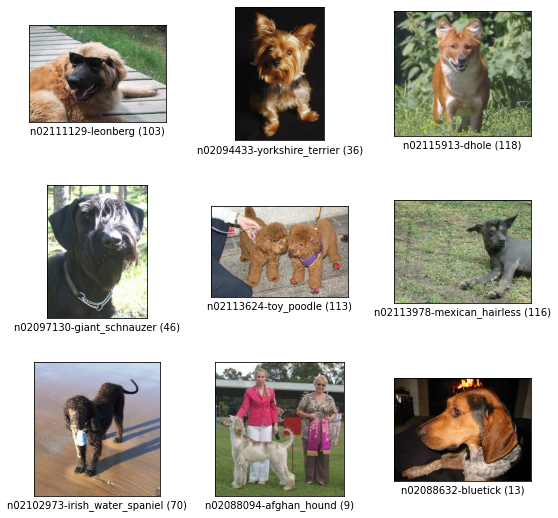

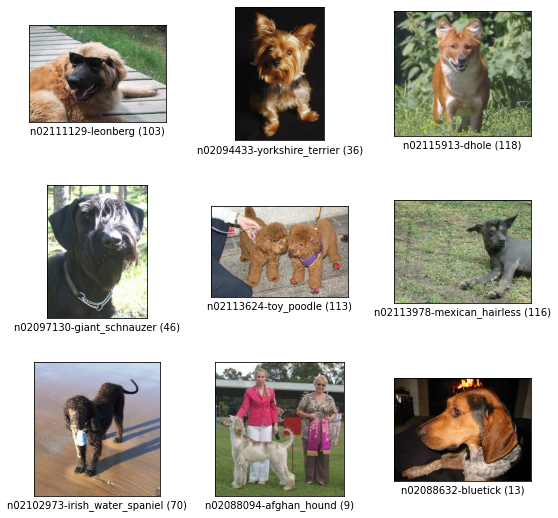

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)

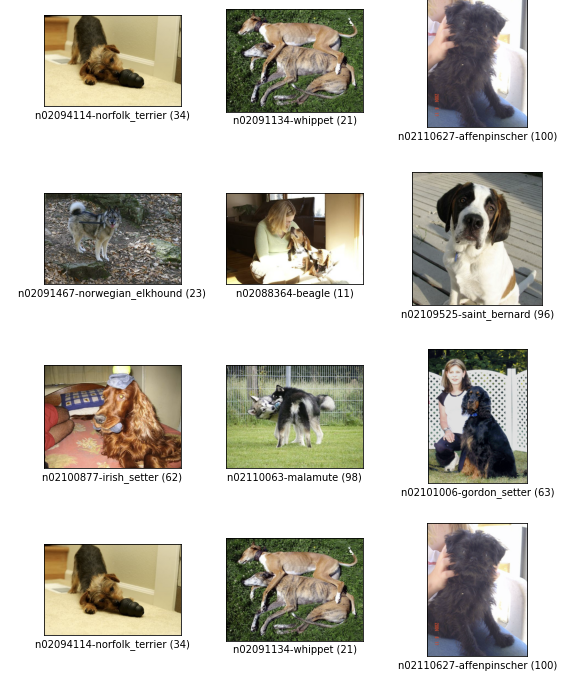

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_basic_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_val = apply_normalize_on_dataset(ds_test, is_test=True)


2. 모델 만들기

In [9]:
def build_resnet_bottleneck_block(input_layer, channel, stride=1, block_num=1, block_idx=1):
    x = input_layer
    shortcut = input_layer

    # 1x1 Conv (감소)
    x = keras.layers.Conv2D(channel, (1,1), strides=stride, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv1')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn1')(x)
    x = keras.layers.Activation('relu')(x)

    # 3x3 Conv
    x = keras.layers.Conv2D(channel, (3,3), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv2')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn2')(x)
    x = keras.layers.Activation('relu')(x)

    # 1x1 Conv (증가)
    x = keras.layers.Conv2D(channel*4, (1,1), strides=1, padding='same', use_bias=False,
                            kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_conv3')(x)
    x = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_bn3')(x)

    # shortcut 처리
    if (input_layer.shape[-1] != channel*4) or (stride != 1):
        shortcut = keras.layers.Conv2D(channel*4, (1,1), strides=stride, padding='same', use_bias=False,
                                       kernel_initializer='he_normal', name=f'bottleneck{block_num}_{block_idx}_shortcut_conv')(shortcut)
        shortcut = keras.layers.BatchNormalization(name=f'bottleneck{block_num}_{block_idx}_shortcut_bn')(shortcut)

    x = keras.layers.Add(name=f'bottleneck{block_num}_{block_idx}_add')([x, shortcut])
    x = keras.layers.Activation('relu', name=f'bottleneck{block_num}_{block_idx}_out')(x)
    return x

In [ ]:
def build_resnet(input_shape=(224,224,3),
                 num_blocks_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=120,
                 block_type='basic'):  
    assert len(num_blocks_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer

    # 초기 Conv-BN-ReLU
    x = keras.layers.Conv2D(64, (7,7), strides=2, padding='same', 
                           use_bias=False, kernel_initializer='he_normal', 
                           name='conv1')(x)
    x = keras.layers.BatchNormalization(name='bn1')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((3,3), strides=2, padding='same')(x)

    # residual blocks
    for block_num, (num_blocks, channel) in enumerate(zip(num_blocks_list, channel_list)):
        for block_idx in range(num_blocks):
            stride = 2 if (block_idx == 0 and block_num != 0) else 1
            if block_type == 'basic':
                x = build_resnet_basic_block(x, channel, stride=stride, block_num=block_num+1, block_idx=block_idx+1)
            elif block_type == 'bottleneck':
                x = build_resnet_bottleneck_block(x, channel, stride=stride, block_num=block_num+1, block_idx=block_idx+1)
            else:
                raise ValueError("block_type should be 'basic' or 'bottleneck'")

    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs=input_layer, outputs=x)
    return model

In [11]:
'''
resnet50 = build_resnet(block_type='bottleneck')
resnet50.summary()
'''

"\nresnet50 = build_resnet(block_type='bottleneck')\nresnet50.summary()\n"

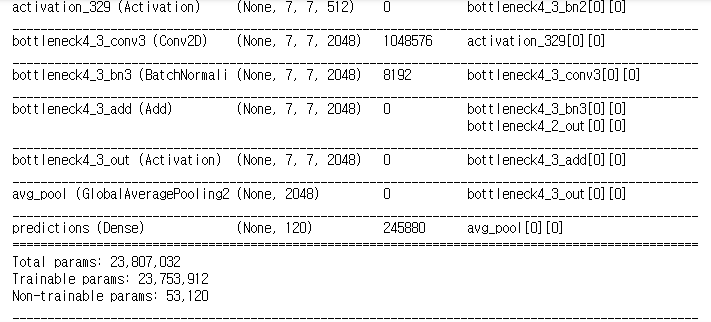

3. 모델 훈련하기

In [12]:
def train_model(dataset, name):
    model = build_resnet(input_shape=(224,224,3), num_classes=120, block_type='bottleneck')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        dataset,
        validation_data=ds_val,
        epochs=20,
        steps_per_epoch=int(ds_info.splits['train'].num_examples // batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples // batch_size),
        verbose=2
    )
    return history


In [13]:
histories = {
    'No Aug': train_model(ds_train_no_aug, 'No Augmentation'),
    'Basic Aug': train_model(ds_train_basic_aug, 'Basic Augmentation'),
    'CutMix': train_model(ds_train_cutmix, 'CutMix'),
    'MixUp': train_model(ds_train_mixup, 'MixUp')
}


Epoch 1/20
375/375 - 210s - loss: 5.0147 - accuracy: 0.0157 - val_loss: 4.6498 - val_accuracy: 0.0212
Epoch 2/20
375/375 - 140s - loss: 4.5125 - accuracy: 0.0298 - val_loss: 5.8539 - val_accuracy: 0.0216
Epoch 3/20
375/375 - 158s - loss: 4.3083 - accuracy: 0.0466 - val_loss: 35.9805 - val_accuracy: 0.0177
Epoch 4/20
375/375 - 141s - loss: 4.0926 - accuracy: 0.0676 - val_loss: 5.4994 - val_accuracy: 0.0500
Epoch 5/20
375/375 - 140s - loss: 3.9191 - accuracy: 0.0868 - val_loss: 5.1754 - val_accuracy: 0.0504
Epoch 6/20
375/375 - 141s - loss: 3.7186 - accuracy: 0.1104 - val_loss: 4.2556 - val_accuracy: 0.0630
Epoch 7/20
375/375 - 140s - loss: 3.5190 - accuracy: 0.1386 - val_loss: 5.1749 - val_accuracy: 0.0470
Epoch 8/20
375/375 - 140s - loss: 3.3025 - accuracy: 0.1734 - val_loss: 4.1375 - val_accuracy: 0.0784
Epoch 9/20
375/375 - 140s - loss: 3.0432 - accuracy: 0.2201 - val_loss: 4.1294 - val_accuracy: 0.0991
Epoch 10/20
375/375 - 140s - loss: 2.7902 - accuracy: 0.2691 - val_loss: 4.2440 -

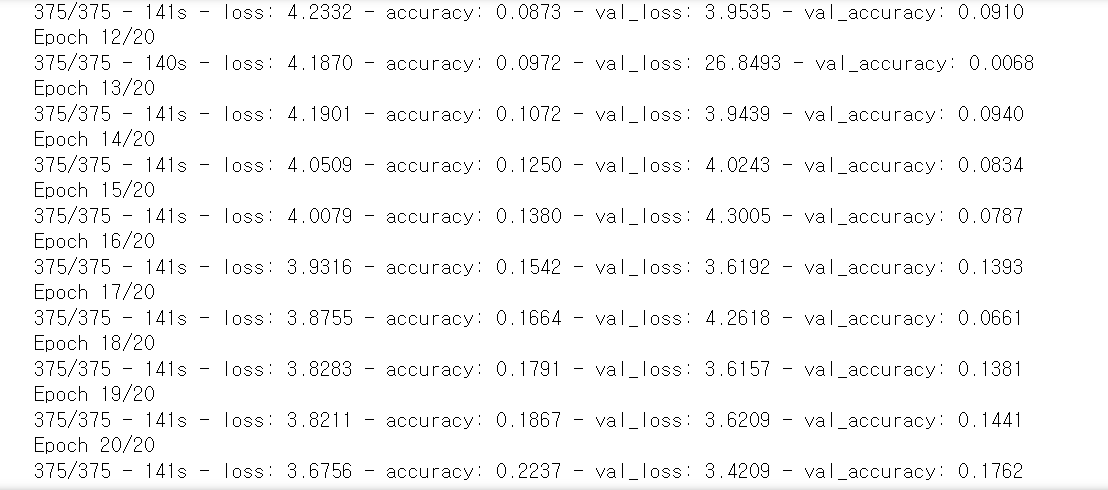

4. 훈련 과정 시각화하기

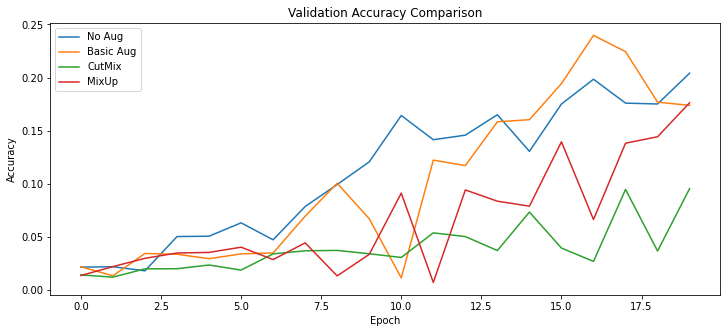

In [14]:
plt.figure(figsize=(12, 5))
# 검증 정확도
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


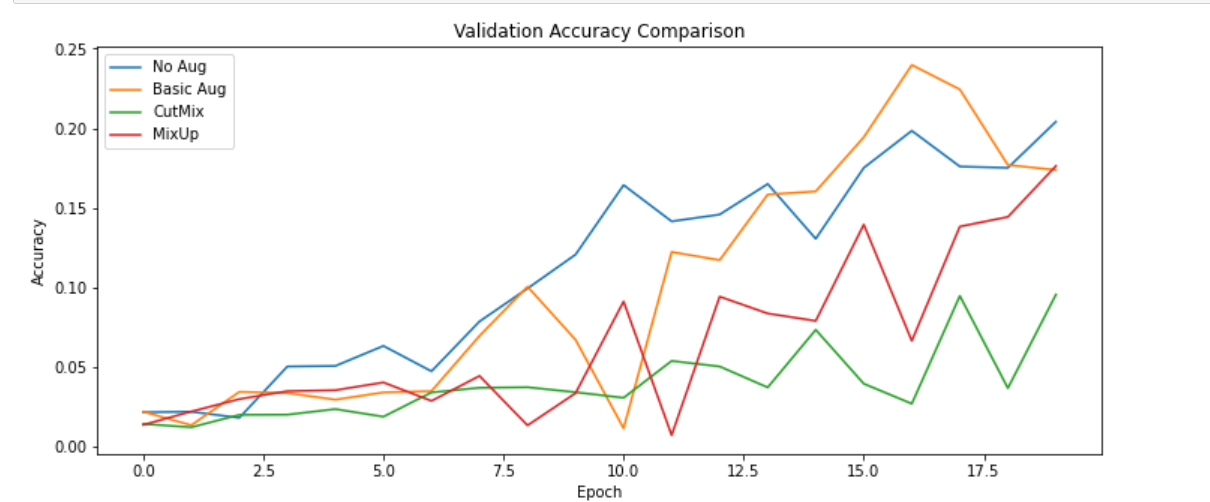

In [22]:
for name, hist in histories.items():
    test_loss, test_acc = hist.model.evaluate(ds_val)
    print(f"{name} 검증 정확도: {hist.history['val_accuracy'][-1]:.4f}")
    print(f"{name} 테스트 정확도: {test_acc:.4f}\n")


269/269 [==============================] - 21s 79ms/step - loss: 5.9062 - accuracy: 0.2040
No Aug 검증 정확도: 0.2041
No Aug 테스트 정확도: 0.2040

269/269 [==============================] - 22s 81ms/step - loss: 4.4705 - accuracy: 0.1737
Basic Aug 검증 정확도: 0.1737
Basic Aug 테스트 정확도: 0.1737

269/269 [==============================] - 23s 83ms/step - loss: 4.0161 - accuracy: 0.0952
CutMix 검증 정확도: 0.0953
CutMix 테스트 정확도: 0.0952

269/269 [==============================] - 24s 88ms/step - loss: 3.4212 - accuracy: 0.1762
MixUp 검증 정확도: 0.1762
MixUp 테스트 정확도: 0.1762



In [1]:
plt.figure(figsize=(12, 5))
for name, hist in histories.items():
    plt.plot(hist.history['val_loss'], label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
noise_accs = {}
for name, hist in histories.items():
    test_loss, test_acc = hist.model.evaluate(ds_test_noisy, verbose=0)
    noise_accs[name] = test_acc

plt.figure(figsize=(8, 5))
plt.bar(noise_accs.keys(), noise_accs.values())
plt.title('Accuracy on Noisy Test Set')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 예측 결과 얻기
model = histories['CutMix'].model
y_pred = model.predict(ds_val)
y_true = np.concatenate([y.numpy() for _, y in ds_val], axis=0)
cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix (CutMix)')
plt.show()


In [15]:
'''
# 데이터 파이프라인
train_ds = apply_normalize_on_dataset(
    ds_train, 
    is_test=False, 
    batch_size=batch_size, 
    with_aug=True, 
    with_cutmix=True
)

val_ds = apply_normalize_on_dataset(
    ds_test, 
    is_test=True, 
    batch_size=batch_size
)
'''

'\n# 데이터 파이프라인\ntrain_ds = apply_normalize_on_dataset(\n    ds_train, \n    is_test=False, \n    batch_size=batch_size, \n    with_aug=True, \n    with_cutmix=True\n)\n\nval_ds = apply_normalize_on_dataset(\n    ds_test, \n    is_test=True, \n    batch_size=batch_size\n)\n'

In [16]:
'''
# 모델 생성
model = build_resnet(
    input_shape=(224,224,3),
    num_classes=num_classes,
    block_type='bottleneck'
)

# 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
'''

"\n# 모델 생성\nmodel = build_resnet(\n    input_shape=(224,224,3),\n    num_classes=num_classes,\n    block_type='bottleneck'\n)\n\n# 컴파일\nmodel.compile(\n    optimizer=keras.optimizers.Adam(learning_rate=1e-3),\n    loss='categorical_crossentropy',\n    metrics=['accuracy']\n)\n"

In [17]:
'''
# 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    steps_per_epoch=int(ds_info.splits['train'].num_examples // batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples // batch_size)
)
'''

"\n# 학습\nhistory = model.fit(\n    train_ds,\n    validation_data=val_ds,\n    epochs=1,\n    steps_per_epoch=int(ds_info.splits['train'].num_examples // batch_size),\n    validation_steps=int(ds_info.splits['test'].num_examples // batch_size)\n)\n"

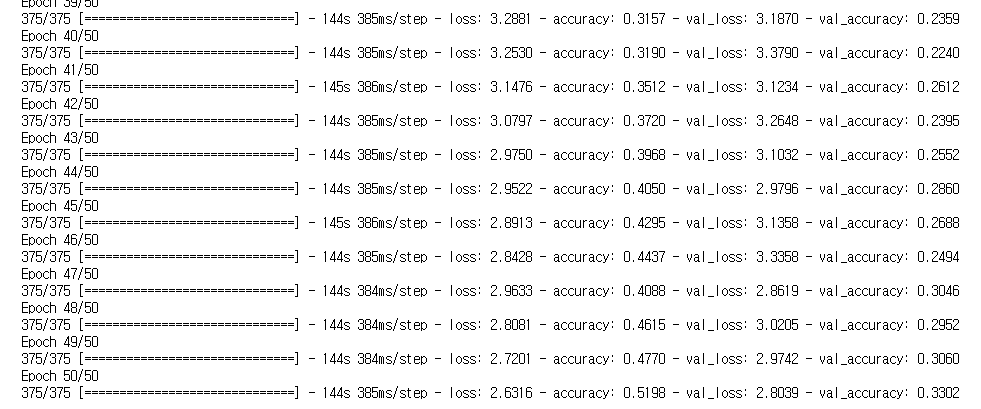

In [18]:
'''
plt.figure(figsize=(12, 5))

# 1) Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r-', label='ResNet50')
plt.plot(history.history['loss'], 'b-', label='PlainNet50')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], 'r-', label='ResNet50')
plt.plot(history.history['val_accuracy'], 'b-', label='PlainNet50')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
'''

"\nplt.figure(figsize=(12, 5))\n\n# 1) Training Loss\nplt.subplot(1, 2, 1)\nplt.plot(history.history['loss'], 'r-', label='ResNet50')\nplt.plot(history.history['loss'], 'b-', label='PlainNet50')\nplt.title('Training Loss per Epoch')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\n\n# 2) Validation Accuracy\nplt.subplot(1, 2, 2)\nplt.plot(history.history['val_accuracy'], 'r-', label='ResNet50')\nplt.plot(history.history['val_accuracy'], 'b-', label='PlainNet50')\nplt.title('Validation Accuracy per Epoch')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n"

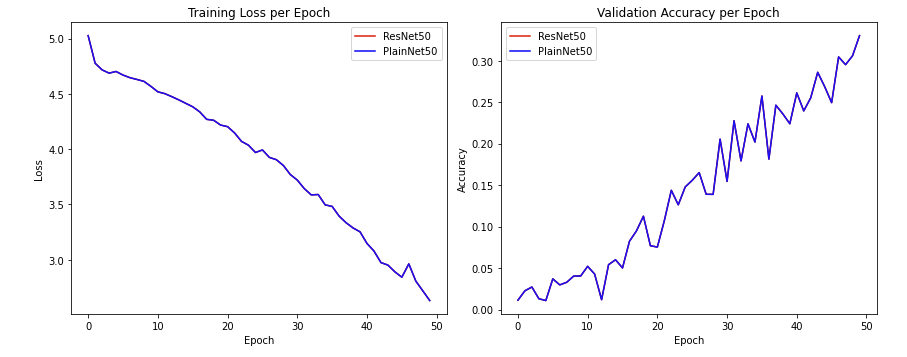

In [19]:
'''
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], 'r--', label='ResNet50 Loss')
plt.plot(history.history['val_accuracy'], 'r-', label='ResNet50 Val Acc')
plt.title('Loss and Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
'''

"\nplt.figure(figsize=(8, 6))\nplt.plot(history.history['loss'], 'r--', label='ResNet50 Loss')\nplt.plot(history.history['val_accuracy'], 'r-', label='ResNet50 Val Acc')\nplt.title('Loss and Validation Accuracy')\nplt.xlabel('Epoch')\nplt.legend()\nplt.show()\n"

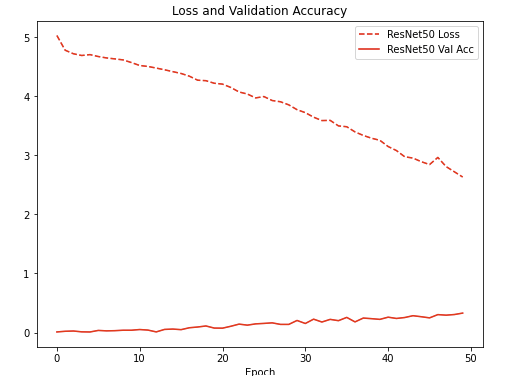

데이터 형태 오류 체크

In [ ]:
for images, labels in train_ds.take(1):
    print("이미지 dtype:", images.dtype)  
    print("레이블 dtype:", labels.dtype)   
    print("이미지 shape:", images.shape)  
    print("레이블 shape:", labels.shape)   


NameError: name 'train_ds' is not defined

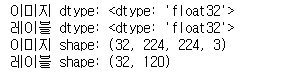

# 회고
모델들에 대해 cutmix와 mixup기법을 사용하였을떄 일반 Augmentation보다 성능이 좋을 것으로 판단이 되었으나 실제로는 성능이 떨어졌다.
왜 그런지 판단을 하였을떄 초기화되어 데이터를 뜯어보는것은 그래프와 성능표까지밖에 하지 못하였으나,데이터 자체가
한정적이고 클래스가 적은상태에서 cutmix와 mixup을 하였을 떄 오히려 더 헷갈리게 만들어,말그대로 노이즈만 더 생성하여
판단하기 더 어려워졌다고 판단을 내렸다.추가적인 검증은 데이터를 더 분석하고 다른 데이터를 넣어 모델에는 문제가 없는지
진짜로 클래스가 적어 헷갈리게 된건지 판단할 필요성이 있다.
예측과 결과는 항상 체크해야하고 데이터 분석에 대해 좀 더 다양한 방법을 고민하고 적용해볼 필요성을 느낀다.